# BESS-STIC Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the STIC-JPL model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the STIC-JPL model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the PT-JPL-SM model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from BESS_JPL import process_BESS_table
from STIC_JPL import process_STIC_table, load_ECOv002_calval_STIC_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [3]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out rows where `fAPARmax` is zero. The resulting DataFrame is displayed for inspection.

In [4]:
input_df = load_ECOv002_calval_STIC_inputs()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,KG_climate,CI,canopy_height_meters,COT,AOT,Ca,wind_speed_mps,vapor_gccm,ozone_cm,Rn_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,3,0.282353,20.642902,0,0,400,0,0,0.3,393.85710
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,4,0.286275,0.000000,0,0,400,0,0,0.3,643.47500
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,4,0.286275,0.000000,0,0,400,0,0,0.3,628.76870
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,4,0.286275,0.000000,0,0,400,0,0,0.3,626.95960
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,4,0.286275,0.000000,0,0,400,0,0,0.3,513.13380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,3,0.301961,0.000000,0,0,400,0,0,0.3,163.24739
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,3,0.301961,0.000000,0,0,400,0,0,0.3,166.19196
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,3,0.301961,0.000000,0,0,400,0,0,0.3,235.88159
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,3,0.301961,0.000000,0,0,400,0,0,0.3,247.87890


## Define Processing Function for Model Table

This cell defines a helper function that processes the input DataFrame through the Verma net radiation calculation and then the PT-JPL-SM model. This function is used in later analysis steps.

In [5]:
def process_BESS_STIC_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_STIC_table(process_BESS_table(input_df))

## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the Verma net radiation and PT-JPL-SM model, and displays the resulting DataFrame.

In [6]:
processed = process_BESS_STIC_table(input_df)
processed

[2025-09-10 16:55:00 INFO] started extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:00 INFO] completed extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:00 INFO] started extracting time from PT-JPL-SM input table
[2025-09-10 16:55:00 INFO] completed extracting time from PT-JPL-SM input table
[2025-09-10 16:55:00 INFO] variable elevation_km min: 0.001 mean: 0.993 max: 3.504 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable Ta_C min: -14.605 mean: 22.322 max: 39.710 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable RH min: 0.273 mean: 0.427 max: 0.984 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable NDVI_minimum min: -0.033 mean: 0.174 max: 0.591 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable NDVI_maximum min: 0.314 mean: 0.628 max: 0.918 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable C4_fraction min: 0.000 mean: 0.296 max: 0.939 nan: 0.00% (nan)
[2025-09-10 16:55:00 INFO] variable carbon_uptake_efficiency min: 0.080 mean: 0.083 max: 0

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,LE_Wm2,LE_soil_Wm2,LE_canopy_Wm2,G_Wm2,LE_max_change,iteration,LE_change,LE_transpiration_Wm2,PT,PET_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,473.185652,69.342528,184.004129,70.388795,1.88147,25,0.000000,305.913113,780.080313,903.223574
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,343.698451,100.628336,125.136978,94.207946,1.88147,25,0.000224,307.581529,681.705062,719.102137
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,489.216458,210.893323,135.914517,102.383488,1.88147,25,0.002299,386.269375,663.283235,706.163845
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,361.052580,207.202548,129.500884,76.011495,1.88147,25,0.000229,310.398867,613.688680,652.117110
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,284.108077,140.032444,119.645512,68.180162,1.88147,25,0.000169,248.072014,510.002523,540.700755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,126.415402,41.487784,5.193484,5.915105,1.88147,25,0.078808,68.011820,246.372752,314.434654
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,204.630101,31.172926,11.745809,24.734375,1.88147,25,0.293415,151.396342,352.514946,396.945105
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,6.443778,6.239409,41.129234,53.271558,1.88147,25,0.000000,6.443778,2557.752176,2557.752176
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,87.515598,48.996907,10.137635,25.234063,1.88147,25,0.000001,67.932190,248.806921,287.536965


In [7]:
processed = processed.dropna(subset=['LEcorr50', 'LE_Wm2', 'ST_C'])
processed

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,LE_Wm2,LE_soil_Wm2,LE_canopy_Wm2,G_Wm2,LE_max_change,iteration,LE_change,LE_transpiration_Wm2,PT,PET_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,473.185652,69.342528,184.004129,70.388795,1.88147,25,0.000000,305.913113,780.080313,903.223574
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,343.698451,100.628336,125.136978,94.207946,1.88147,25,0.000224,307.581529,681.705062,719.102137
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,489.216458,210.893323,135.914517,102.383488,1.88147,25,0.002299,386.269375,663.283235,706.163845
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,361.052580,207.202548,129.500884,76.011495,1.88147,25,0.000229,310.398867,613.688680,652.117110
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,284.108077,140.032444,119.645512,68.180162,1.88147,25,0.000169,248.072014,510.002523,540.700755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,126.415402,41.487784,5.193484,5.915105,1.88147,25,0.078808,68.011820,246.372752,314.434654
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,204.630101,31.172926,11.745809,24.734375,1.88147,25,0.293415,151.396342,352.514946,396.945105
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,6.443778,6.239409,41.129234,53.271558,1.88147,25,0.000000,6.443778,2557.752176,2557.752176
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,87.515598,48.996907,10.137635,25.234063,1.88147,25,0.000001,67.932190,248.806921,287.536965


## Accuracy Comparison of In-Situ Latent Heat Flux to STIC-JPL Latent Heat Flux

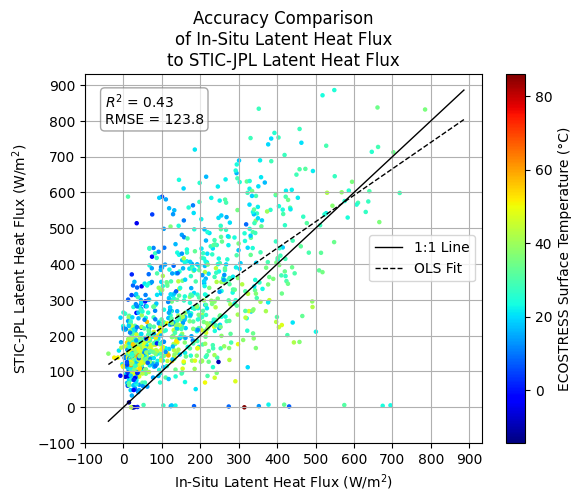

In [8]:
sc = plt.scatter(
    x=processed.LEcorr50,
    y=processed.LE_Wm2,
    c=processed.ST_C,
    cmap="jet",
    color=None,
    s=5
)

# Add 1-to-1 line
min_val = min(processed.LEcorr50.min(), processed.LE_Wm2.min())
max_val = max(processed.LEcorr50.max(), processed.LE_Wm2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

# Add OLS regression line
coefs = np.polyfit(processed.LEcorr50, processed.LE_Wm2, 1)
ols_x = np.array([min_val, max_val])
ols_y = coefs[0] * ols_x + coefs[1]
plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

# Calculate R-squared and RMSE
from sklearn.metrics import r2_score, mean_squared_error
y_true = processed.LE_Wm2
y_pred = coefs[0] * processed.LEcorr50 + coefs[1]
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Annotate R-squared and RMSE on plot
plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top',
             fontsize=10,
             bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

# Set ticks every 100 for both axes
xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
plt.xticks(xticks)
plt.yticks(yticks)

plt.grid(True, zorder=0) 
plt.xlabel("In-Situ Latent Heat Flux (W/m$^2$)")
plt.ylabel("STIC-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Accuracy Comparison\nof In-Situ Latent Heat Flux\nto STIC-JPL Latent Heat Flux")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.legend()
plt.savefig("Accuracy Comparison of In-Situ Latent Heat Flux to STIC-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Accuracy Comparison of In-Situ Latent Heat Flux to STIC-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')
plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Latent Heat Flux

This cell creates a scatter plot comparing ECOSTRESS surface temperature to STIC-JPL latent heat flux for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

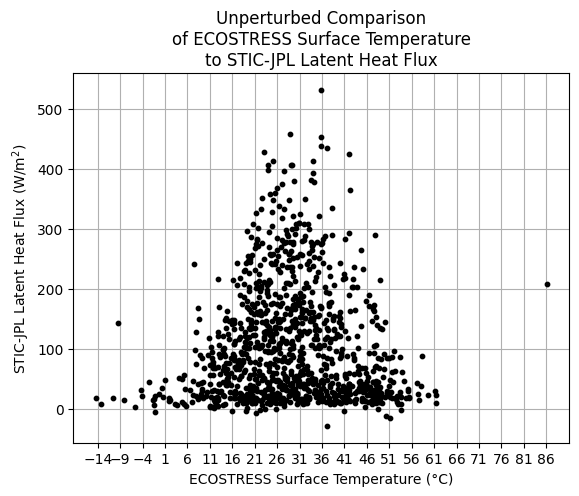

In [9]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.LE, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("STIC-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto STIC-JPL Latent Heat Flux")

plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to STIC-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to STIC-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Further Filter Input Data and Check Temperature Range

This cell applies additional filters to the input data, ensuring only valid `NDVI` values are included. It also checks the minimum and maximum surface temperature values in the filtered dataset.

In [10]:
# input_df = pd.read_csv(input_filename)
input_df = load_ECOv002_calval_STIC_inputs()

if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.ST_C), np.nanmax(input_df.ST_C)

(np.float64(-13.189999999999998), np.float64(86.11000000000001))

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [11]:
len(input_df)

1063

## Run Perturbed Model Analysis

This cell sets up the input and output variables for the sensitivity analysis and runs the `perturbed_run` function, which perturbs the input variable and observes the effect on the output variable using the PM-JPL model. The results are displayed for further analysis.

In [12]:
input_variable = "ST_C"
output_variable = "LE_Wm2"

results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_BESS_STIC_table,
    normalization_function=normalization_function
)

results

[2025-09-10 16:55:01 INFO] tarting Monte Carlo perturbed run
[2025-09-10 16:55:01 INFO] calculating standard deviation of input variable: ST_C
[2025-09-10 16:55:01 INFO] input variable ST_C standard deviation: 12.285657205245933
[2025-09-10 16:55:01 INFO] starting forward process
[2025-09-10 16:55:01 INFO] started extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:01 INFO] completed extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:01 INFO] started extracting time from PT-JPL-SM input table
[2025-09-10 16:55:01 INFO] completed extracting time from PT-JPL-SM input table
[2025-09-10 16:55:01 INFO] variable elevation_km min: 0.001 mean: 0.994 max: 3.504 nan: 0.00% (nan)
[2025-09-10 16:55:01 INFO] variable Ta_C min: -14.605 mean: 22.380 max: 39.710 nan: 0.00% (nan)
[2025-09-10 16:55:01 INFO] variable RH min: 0.273 mean: 0.427 max: 0.984 nan: 0.00% (nan)
[2025-09-10 16:55:01 INFO] variable NDVI_minimum min: -0.033 mean: 0.174 max: 0.591 nan: 0.00% (nan)
[2025-09

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,17.968240,0.562386,49.91824,473.185652,-380.152318,0.803389,93.033333
1,ST_C,LE_Wm2,31.95,-18.491103,0.578751,13.458897,473.185652,156.817411,0.331408,630.003063
2,ST_C,LE_Wm2,31.95,3.171319,0.099259,35.121319,473.185652,-125.661535,0.265565,347.524117
3,ST_C,LE_Wm2,31.95,-15.144901,0.474019,16.805099,473.185652,98.130491,0.207383,571.316143
4,ST_C,LE_Wm2,31.95,10.194496,0.319077,42.144496,473.185652,-287.574548,0.607741,185.611104
...,...,...,...,...,...,...,...,...,...,...
106295,ST_C,LE_Wm2,41.61,6.555348,0.157543,48.165348,252.556758,-96.187859,0.380856,156.368899
106296,ST_C,LE_Wm2,41.61,-16.118482,0.387370,25.491518,252.556758,-246.190954,0.974795,6.365804
106297,ST_C,LE_Wm2,41.61,6.289136,0.151145,47.899136,252.556758,-93.011959,0.368281,159.544799
106298,ST_C,LE_Wm2,41.61,18.827780,0.452482,60.43778,252.556758,-188.624835,0.746861,63.931923


## Filter Out NaN Results

This cell removes any rows with missing values from the perturbed results to ensure only valid data points are used in subsequent analysis and plotting.

In [13]:
filtered_results = results.dropna()
filtered_results

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,17.968240,0.562386,49.91824,473.185652,-380.152318,0.803389,93.033333
1,ST_C,LE_Wm2,31.95,-18.491103,0.578751,13.458897,473.185652,156.817411,0.331408,630.003063
2,ST_C,LE_Wm2,31.95,3.171319,0.099259,35.121319,473.185652,-125.661535,0.265565,347.524117
3,ST_C,LE_Wm2,31.95,-15.144901,0.474019,16.805099,473.185652,98.130491,0.207383,571.316143
4,ST_C,LE_Wm2,31.95,10.194496,0.319077,42.144496,473.185652,-287.574548,0.607741,185.611104
...,...,...,...,...,...,...,...,...,...,...
106295,ST_C,LE_Wm2,41.61,6.555348,0.157543,48.165348,252.556758,-96.187859,0.380856,156.368899
106296,ST_C,LE_Wm2,41.61,-16.118482,0.387370,25.491518,252.556758,-246.190954,0.974795,6.365804
106297,ST_C,LE_Wm2,41.61,6.289136,0.151145,47.899136,252.556758,-93.011959,0.368281,159.544799
106298,ST_C,LE_Wm2,41.61,18.827780,0.452482,60.43778,252.556758,-188.624835,0.746861,63.931923


## Plot Change in Surface Temperature vs Latent Heat Flux

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in PM-JPL latent heat flux due to input perturbations. The plot is saved as JPEG and SVG files.

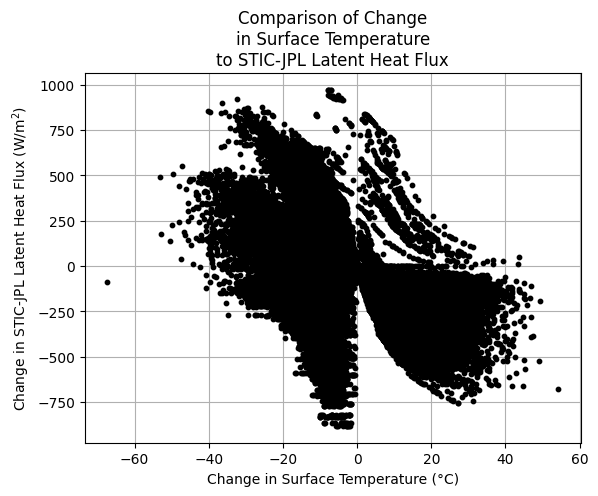

In [14]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=results.input_perturbation, y=results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in STIC-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto STIC-JPL Latent Heat Flux")

plt.savefig("Comparison of Change in Surface Temperature to STIC-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to STIC-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

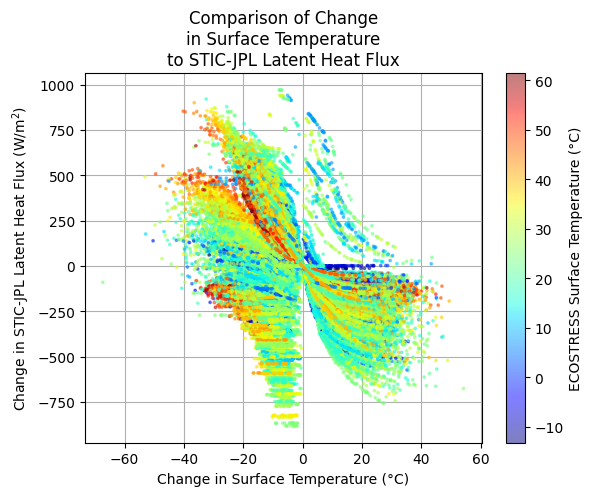

In [15]:
sc = plt.scatter(
    x=results.input_perturbation, 
    y=results.output_perturbation, 
    c=results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in STIC-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto STIC-JPL Latent Heat Flux")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.savefig("Comparison of Change in Surface Temperature to STIC-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to STIC-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Compute Correlation Between Input and Output Perturbations

This cell calculates the Pearson correlation coefficient between the standardized input and output perturbations, quantifying the strength of their linear relationship.

In [16]:
correlation = mstats.pearsonr(
    np.array(filtered_results.input_perturbation_std).astype(np.float64), 
    np.array(filtered_results.output_perturbation_std).astype(np.float64)
)[0]

correlation

np.float64(0.07764523440760941)

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [17]:
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE_Wm2"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_BESS_STIC_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

[2025-09-10 16:55:21 INFO] tarting Monte Carlo perturbed run
[2025-09-10 16:55:21 INFO] calculating standard deviation of input variable: ST_C
[2025-09-10 16:55:21 INFO] input variable ST_C standard deviation: 12.285657205245933
[2025-09-10 16:55:21 INFO] starting forward process
[2025-09-10 16:55:21 INFO] started extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:21 INFO] completed extracting geometry from PT-JPL-SM input table
[2025-09-10 16:55:21 INFO] started extracting time from PT-JPL-SM input table
[2025-09-10 16:55:21 INFO] completed extracting time from PT-JPL-SM input table
[2025-09-10 16:55:21 INFO] variable elevation_km min: 0.001 mean: 0.994 max: 3.504 nan: 0.00% (nan)
[2025-09-10 16:55:21 INFO] variable Ta_C min: -14.605 mean: 22.380 max: 39.710 nan: 0.00% (nan)
[2025-09-10 16:55:21 INFO] variable RH min: 0.273 mean: 0.427 max: 0.984 nan: 0.00% (nan)
[2025-09-10 16:55:21 INFO] variable NDVI_minimum min: -0.033 mean: 0.174 max: 0.591 nan: 0.00% (nan)
[2025-09

/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perturbation_df = pd.concat([perturbation_df, run_results])
/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_metrics_df = pd.concat([sensitivity_metrics_df, pd.DataFrame([[


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[2025-09-10 16:55:34 INFO] variable RVIS min: 0.015 mean: 0.108 max: 0.300 nan: 0.00% (nan)
[2025-09-10 16:55:34 INFO] variable RNIR min: 0.015 mean: 0.108 max: 0.300 nan: 0.00% (nan)
[2025-09-10 16:55:34 INFO] variable PARDir min: 111.324 mean: 305.988 max: 491.893 nan: 0.00% (nan)
[2025-09-10 16:55:34 INFO] variable KG_climate (float32) with [1. 2. 3. 4. 5.] unique values
[2025-09-10 16:55:34 INFO] * 1.0: 3
[2025-09-10 16:55:34 INFO] * 2.0: 473
[2025-09-10 16:55:34 INFO] * 3.0: 172
[2025-09-10 16:55:34 INFO] * 4.0: 411
[2025-09-10 16:55:34 INFO] * 5.0: 4
[2025-09-10 16:55:34 INFO] variable canopy_height_meters min: 0.000 mean: 6.055 max: 30.192 nan: 0.00% (nan)
[2025-09-10 16:55:34 INFO] variable Ca (float64) with [400.] unique values
[2025-09-10 16:55:34 INFO] * 400.0: 1063
[2025-09-10 16:55:34 INFO] variable wind_speed_mps (float64) with [7.4] unique values
[2025-09-10 16:55:34 INFO] * 7.4: 1063
[2025-09-10 16:55:34 WARNING] netrc credentials

/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/BESS_JPL/LAI_from_NDVI.py:26: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


[2025-09-10 16:55:42 INFO] variable APAR_sunlit min: 78.416 mean: 454.449 max: 1637.464 nan: 13.15% (nan)
[2025-09-10 16:55:42 INFO] variable APAR_shaded min: 0.000 mean: 40.960 max: 185.697 nan: 13.15% (nan)
[2025-09-10 16:55:42 INFO] variable ASW_sunlit min: 57.280 mean: 224.203 max: 564.178 nan: 13.15% (nan)
[2025-09-10 16:55:42 INFO] variable ASW_shaded min: 0.144 mean: 25.786 max: 300.483 nan: 13.15% (nan)
[2025-09-10 16:55:42 INFO] variable ASW_soil min: 15.526 mean: 437.860 max: 846.445 nan: 13.15% (nan)
[2025-09-10 16:55:42 INFO] variable G min: 0.000 mean: 51.902 max: 107.875 nan: 13.15% (nan)
[2025-09-10 16:55:43 INFO] variable GPP_C3 min: 0.000 mean: 10.542 max: 40.000 nan: 13.15% (nan)
[2025-09-10 16:55:43 INFO] variable LE_C3 min: 0.000 mean: 113.086 max: 527.381 nan: 0.00% (nan)
[2025-09-10 16:55:43 INFO] variable LE_soil_C3 min: 0.000 mean: 50.837 max: 279.520 nan: 0.00% (nan)
[2025-09-10 16:55:43 INFO] variable LE_canopy_C3 min: 0.000 mean: 62.249 max: 484.131 nan: 0.00

/Users/halverso/Projects/STIC-JPL/STIC_JPL/LAI_from_NDVI.py:59: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


[2025-09-10 16:55:46 INFO] using variable Priestley-Taylor alpha with mean: 4.187
[2025-09-10 16:55:46 INFO] completed STIC iteration 8 / 30 with max LE change: 206.262 (0.19446708398754708 seconds)
[2025-09-10 16:55:46 INFO] variable SM_8 min: 0.000 mean: 0.152 max: 1.000 nan: 0.00% (nan)
[2025-09-10 16:55:46 INFO] variable G_8 min: -0.000 mean: 46.304 max: 166.632 nan: 0.00% (nan)
[2025-09-10 16:55:46 INFO] variable LE_8 min: 0.000 mean: 241.220 max: 930.120 nan: 0.00% (nan)
[2025-09-10 16:55:46 INFO] running STIC iteration 9 / 30
[2025-09-10 16:55:46 INFO] using variable Priestley-Taylor alpha with mean: 4.231
[2025-09-10 16:55:46 INFO] completed STIC iteration 9 / 30 with max LE change: 52.646 (0.2211905839794781 seconds)
[2025-09-10 16:55:46 INFO] variable SM_9 min: 0.000 mean: 0.152 max: 1.000 nan: 0.00% (nan)
[2025-09-10 16:55:46 INFO] variable G_9 min: -0.000 mean: 46.304 max: 166.632 nan: 0.00% (nan)
[2025-09-10 16:55:46 INFO] variable LE_9 min: 0.000 mean: 241.833 max: 930.12

/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/BESS_JPL/meteorology.py:166: RuntimeWarning: invalid value encountered in sqrt
  epsa0 = 0.605 + 0.048 * (Ea_Pa / 100) ** 0.5  # [-]


[2025-09-10 16:56:23 INFO] variable Q_NSunDn min: 1.817 mean: 29.846 max: 163.078 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable Q_NShDn min: 0.008 mean: 4.626 max: 108.532 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable I_NSoil min: 51.784 mean: 316.871 max: 530.806 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable ANIR_Soil min: 36.249 mean: 221.810 max: 371.564 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable Q_NSunUp min: 8.884 mean: 90.758 max: 153.486 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable Q_NShUp min: 0.206 mean: 4.303 max: 24.887 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable ANIR_Sun min: 47.061 mean: 120.604 max: 203.977 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable ANIR_Sh min: 0.213 mean: 8.929 max: 130.415 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable G min: 0.791 mean: 56.293 max: 99.512 nan: 0.00% (nan)
[2025-09-10 16:56:23 INFO] variable sunlit_fraction min: 0.118 mean: 0.240 max: 0.580 nan: 0.00% (nan)
[2025-09-10 16:

/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/BESS_JPL/canopy_energy_balance.py:117: RuntimeWarning: divide by zero encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]
/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/BESS_JPL/canopy_energy_balance.py:117: RuntimeWarning: invalid value encountered in divide
  Ci = Ca - 1.6 * An / gs1  # [umol./mol]
/opt/homebrew/Caskroom/miniforge/base/envs/STIC-JPL/lib/python3.10/site-packages/BESS_JPL/canopy_energy_balance.py:123: RuntimeWarning: divide by zero encountered in divide
  rs = 1.0 / (gs1 / cf * 1e-2)  # [s m-1]


[2025-09-10 16:56:23 INFO] started extracting geometry from PT-JPL-SM input table
[2025-09-10 16:56:24 INFO] completed extracting geometry from PT-JPL-SM input table
[2025-09-10 16:56:24 INFO] started extracting time from PT-JPL-SM input table
[2025-09-10 16:56:24 INFO] completed extracting time from PT-JPL-SM input table
[2025-09-10 16:56:26 INFO] variable Ms min: 0.000 mean: 0.237 max: 1.000 nan: 0.00% (nan)
[2025-09-10 16:56:26 INFO] running STIC iteration 1 / 30
[2025-09-10 16:56:26 INFO] using variable Priestley-Taylor alpha with mean: 1.247
[2025-09-10 16:56:26 INFO] completed STIC iteration 1 / 30 with max LE change: 1086.162 (0.014875708002364263 seconds)
[2025-09-10 16:56:26 INFO] variable SM_1 min: 0.000 mean: 0.158 max: 1.000 nan: 0.00% (nan)
[2025-09-10 16:56:26 INFO] variable G_1 min: 0.000 mean: 58.538 max: 172.964 nan: 0.00% (nan)
[2025-09-10 16:56:26 INFO] variable LE_1 min: -149.194 mean: 247.780 max: 928.303 nan: 0.00% (nan)
[2025-09-10 16:56:26 INFO] running STIC ite

,input_variable,output_variable,metric,value
0,ST_C,LE_Wm2,correlation,0.060427
0,ST_C,LE_Wm2,r2,0.003651
0,ST_C,LE_Wm2,mean_normalized_change,1.973925
0,NDVI,LE_Wm2,correlation,0.547061
0,NDVI,LE_Wm2,r2,0.299276
0,NDVI,LE_Wm2,mean_normalized_change,0.154972
0,albedo,LE_Wm2,correlation,0.530679
0,albedo,LE_Wm2,r2,0.281620
0,albedo,LE_Wm2,mean_normalized_change,0.068321
0,Ta_C,LE_Wm2,correlation,-0.004192


## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input. The plot is saved as JPEG and SVG files with the PT-JPL-SM label.

/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_47780/3304902296.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


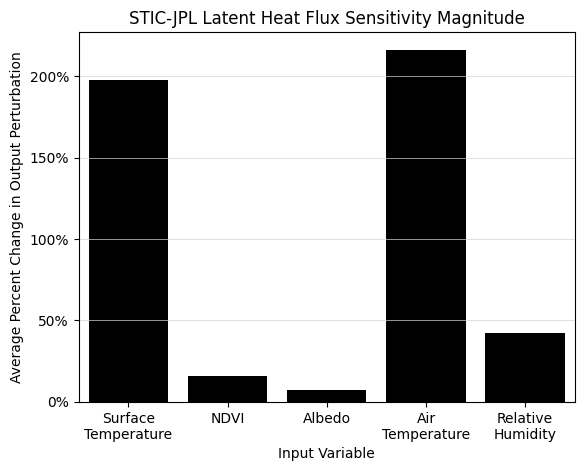

In [18]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE_Wm2") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("STIC-JPL Latent Heat Flux Sensitivity Magnitude")
# plt.ylim(0, 160)  # Set y-axis range from 0 to 160
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("STIC-JPL Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("STIC-JPL Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the PT-JPL-SM model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.